In [1]:
import pickle # for saving objects
import re

import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px # for nice plotting

import warnings

import math

from wordcloud import WordCloud

from nltk.tokenize import RegexpTokenizer # for LSA in sklearn, we will need additional tokenizer

from sklearn.feature_extraction.text import CountVectorizer # one can consider LSA with DF in DTM...
from sklearn.feature_extraction.text import TfidfVectorizer # or with TF-IDF values in DTM

from sklearn.decomposition import LatentDirichletAllocation # LDA implementation

def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/cnn/cnn_data/cnn_data_df_preprocessed.pkl", "rb") as fp:
    cnn_data_df = pickle.load(fp)

In [ ]:
cnn_data_df.head()

0                                                  1    2  \
0  Jan 20, 2023  Brazilian footballer Dani Alves has been detai...  cnn   
1  Jan 20, 2023  Lionel Messi and Cristiano Ronaldo put on a sh...  cnn   
2  Jan 18, 2023  As she finished a Zoom meeting with a colleagu...  cnn   
3  Jan 16, 2023  The red-headed man wearing what looks like the...  cnn   
4  Jan 12, 2023  The US State Department rolled out a tool for ...  cnn   

                                                   3  
0  [brazilian, footballer, dani, alves, detained,...  
1  [lionel, messi, cristiano, ronaldo, put, show,...  
2  [finished, zoom, meeting, colleague, dr, célin...  
3  [red-headed, man, wearing, looks, like, ultima...  
4  [us, state, department, rolled, tool, afghans,...

In [ ]:
# as our preprocessed data is already tokenized
# therefore, we need to make them strings again...

def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele+" "
    return str1

cnn_data_df[4] = cnn_data_df[3] # new column, for now a copy of tokenized and preprocessed texts
for i in range(0,len(cnn_data_df)):
    cnn_data_df[4][i] = listToString(cnn_data_df[4][i])

cnn_data_df

0                                                  1    2  \
0    Jan 20, 2023  Brazilian footballer Dani Alves has been detai...  cnn   
1    Jan 20, 2023  Lionel Messi and Cristiano Ronaldo put on a sh...  cnn   
2    Jan 18, 2023  As she finished a Zoom meeting with a colleagu...  cnn   
3    Jan 16, 2023  The red-headed man wearing what looks like the...  cnn   
4    Jan 12, 2023  The US State Department rolled out a tool for ...  cnn   
..            ...                                                ...  ...   
365  Apr 07, 2022  With months to go until the 2022 World Cup in ...  cnn   
366  Apr 07, 2022  Anatoliy Trubin should be enjoying life as a p...  cnn   
367  Apr 04, 2022  Netherlands coach Louis van Gaal said on Sunda...  cnn   
368  Apr 02, 2022  After more than 40 years of sour relations and...  cnn   
369  Apr 02, 2022  Spain and Germany will face off in the headlin...  cnn   

                                                     3  \
0    [brazilian, footballer, dani, alves, detained,...   
1    [lionel, messi, cristiano, ronaldo, put, show,...   
2    [finished, zoom, meeting, colleague, dr, célin...   
3    [red-headed, man, wearing, looks, like, ultima...   
4    [us, state, department, rolled, tool, afghans,...   
..                                                 ...   
365  [months, go, qatar, less, week, since, draw, t...   
366  [anatoliy, trubin, enjoying, life, professiona...   
367  [netherlands, coach, louis, van, gaal, said, s...   
368  [years, sour, relations, months, struggle, res...   
369  [spain, germany, face, headline, act, group, s...   

                                                     4  
0    brazilian footballer dani alves detained polic...  
1    lionel messi cristiano ronaldo put show came h...  
2    finished zoom meeting colleague dr céline goun...  
3    red-headed man wearing looks like ultimate chr...  
4    us state department rolled tool afghans us par...  
..                                                 ...  
365  months go qatar less week since draw took plac...  
366  anatoliy trubin enjoying life professional foo...  
367  netherlands coach louis van gaal said sunday b...  
368  years sour relations months struggle restore n...  
369  spain germany face headline act group stages d...  

[370 rows x 5 columns]

# Latent Dirichlet Allocation (LDA)

In [ ]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

tokenizer = RegexpTokenizer(r'\w+') # tokenizer

tf_vectorizer = CountVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                max_df = 0.75, #filtering with document frequency
                                min_df = 5/len(cnn_data_df[4]), #filtering with document frequency
                                tokenizer = tokenizer.tokenize
)
tf = tf_vectorizer.fit_transform(cnn_data_df[4])
tf_feature_names = tf_vectorizer.get_feature_names()

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3), #let us use unigrams for now, to make the calculations quicker
                                   max_df = 0.75, #filtering with document frequency
                                   min_df = 5/len(cnn_data_df[4]), #filtering with document frequency
                                   tokenizer = tokenizer.tokenize
)
tfidf = tfidf_vectorizer.fit_transform(cnn_data_df[4])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
lda = LatentDirichletAllocation(
                                doc_topic_prior = None,
                                # prior theta/alpha
                                # i.e. document - topic distribution;
                                # None means 1/n_components

                                topic_word_prior = None,
                                # prior beta/eta
                                # i.e. topic - word distribution

                                learning_method = 'online',
                                # method used in fit();
                                # 'batch' stands for variational Bayes method
                                # 'online' stands for using mini-batch
                                # on data in every EM iteration;
                                # in case of a huge dataset, 'online'
                                # is recommended as a faster option

                                learning_decay = 0.7,
                                # if using 'online' learning method,
                                # this indicates bini-batch size

                                learning_offset = 50.0,
                                # this parameter downweights early iterations
                                # in online learning

                                max_iter = 50,
                                # iterations in fit()

                                batch_size = 128,
                                # number of documnets to be used in a batch
                                # in 'online' learning

                                evaluate_every = -1,
                                # if ones want to evaluate perplexity
                                # every x iterations; negative number
                                # means no perplexity evaluation and
                                # procceding

                                total_samples = 1000000.0,
                                # total number of documents for partial_fit()
                                # method

                                perp_tol = 0.1,
                                # perplexity tolerance if we use
                                # evaluate_every option

                                mean_change_tol = 0.001,
                                # stopping tolerance for E-step in EM

                                max_doc_update_iter = 100,
                                # max number of iterations for E-step in EM

                                n_jobs = None,
                                # number of jobs to be done in E-step

                                verbose = 1,
                                # whether to print some parameters

                                random_state = 123
)

lda.fit(tf)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, random_state=123, verbose=1)

In [ ]:
for index, component in enumerate(lda.components_): #taking model's components, i.e. P(w|z)
    zipped = zip(tf_vectorizer.get_feature_names(), component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['team', 'match', 'first', 'game', 'goal', 'players', 'argentina', 'group', 'tournament', 'two']
Topic 1:  ['soccer', 'us', 'team', 'players', 'first', 'before', 'tournament', 'pelé', 'saudi', 'game']
Topic 2:  ['messi', 'first', 'argentina', 'game', 'match', 'france', 'goal', 'final', 'team', 'two']
Topic 3:  ['match', 'fifa', 'armband', 'portugal', 'switzerland', 'korea', 'ronaldo', 'coverage', 'south', 'match coverage']
Topic 4:  ['us', 'workers', 'cnn', 'year', 'first', 'also', 'tournament', 'people', 'told', 'fifa']
Topic 5:  ['team', 'messi', 'first', 'france', 'match', 'argentina', 'tournament', 'final', 'year', 'two']
Topic 6:  ['argentina', 'morocco', 'game', 'first', 'tournament', 'match', 'two', 'football', 'teams', 'messi']
Topic 7:  ['russian', 'ukraine', 'us', 'ukrainian', 'people', 'russia', 'also', 'cnn', 'country', 'city']
Topic 8:  ['wahl', 'soccer', 'grant', 'us', 'grant wahl', 'sports', 'death', 'family', 'gounder', 'us soccer']
Topic 9:  ['people', 'tourn

In [ ]:
lda = LatentDirichletAllocation(
                                doc_topic_prior = None,
                                # prior theta/alpha
                                # i.e. document - topic distribution;
                                # None means 1/n_components

                                topic_word_prior = None,
                                # prior beta/eta
                                # i.e. topic - word distribution

                                learning_method = 'online',
                                # method used in fit();
                                # 'batch' stands for variational Bayes method
                                # 'online' stands for using mini-batch
                                # on data in every EM iteration;
                                # in case of a huge dataset, 'online'
                                # is recommended as a faster option

                                learning_decay = 0.7,
                                # if using 'online' learning method,
                                # this indicates bini-batch size

                                learning_offset = 50.0,
                                # this parameter downweights early iterations
                                # in online learning

                                max_iter = 50,
                                # iterations in fit()

                                batch_size = 128,
                                # number of documnets to be used in a batch
                                # in 'online' learning

                                evaluate_every = -1,
                                # if ones want to evaluate perplexity
                                # every x iterations; negative number
                                # means no perplexity evaluation and
                                # procceding

                                total_samples = 1000000.0,
                                # total number of documents for partial_fit()
                                # method

                                perp_tol = 0.1,
                                # perplexity tolerance if we use
                                # evaluate_every option

                                mean_change_tol = 0.001,
                                # stopping tolerance for E-step in EM

                                max_doc_update_iter = 100,
                                # max number of iterations for E-step in EM

                                n_jobs = None,
                                # number of jobs to be done in E-step

                                verbose = 1,
                                # whether to print some parameters

                                random_state = 123
)

lda.fit(tfidf)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, random_state=123, verbose=1)

In [ ]:
for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['team', 'match', 'us', 'fifa', 'messi', 'first', 'tournament', 'game', 'football', 'argentina']
Topic 1:  ['players', 'saudi', 'ronaldo', 'mbappé', 'need know', 'club', 'arabia', 'given', 'milan', 'achieving']
Topic 2:  ['messi', 'because something', 'magic', 'angel di', 'croatias', 'final whistle during', 'new york times', 'rashford', 'taken granted', 'stages qatar']
Topic 3:  ['match', 'team', 'iran', 'messi', 'argentina', 'first', 'goal', 'us', 'fifa', 'game']
Topic 4:  ['drugs', 'region', 'lasted', 'beckham', 'russian', 'fifa human rights', 'migrant workers', 'formal', 'president volodymyr zelensky', 'crucial group']
Topic 5:  ['korea', 'per', 'earlier today', 'team', 'finals', 'heart', 'win game', 'deutsche telekom', 'rising', 'endured']
Topic 6:  ['make match', 'touched', 'licensed venues', 'contributed reporting post', 'sides first', 'along way', 'human rights death', 'gulf', 'impossible', 'hit back']
Topic 7:  ['team', 'workers', 'russian', 'ukraine', 'ramos', 'kyiv'

### Finding optimal number of topics in LDA

In [ ]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [ ]:
measures_specific = []

for n_topics in range(2,51,1):

    print('Trying parameters:', n_topics)

    lda = LatentDirichletAllocation(n_components = n_topics,
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 100,
                                    random_state = 123)

    lda.fit(tf)

    avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

In [ ]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_df_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

save_object(measures_specific_df_lda, '/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/cnn/cnn_data/measures_specific_df_lda_cnn.pkl')

In [ ]:
with open("/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/cnn/cnn_data/measures_specific_df_lda_cnn.pkl", "rb") as fp:
    measures_specific_df_lda = pickle.load(fp)

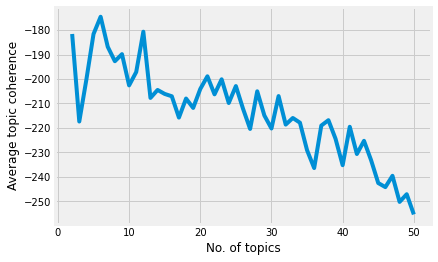

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_df_lda['n_topics'],measures_specific_df_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [ ]:
measures_specific_df_lda.sort_values('avg_coherence', ascending = False).iloc[0:9,:]

avg_coherence  n_topics
4     -174.551631         6
10    -180.663155        12
0     -181.602477         2
3     -181.633363         5
5     -186.842431         7
7     -189.839871         9
6     -192.732158         8
9     -197.136507        11
19    -198.895444        21

### Let us try optimizing the number of topics for LDA with TfidfVectorizer() applied.

In [ ]:
warnings.filterwarnings("ignore") #ignoring popping up warnings

measures_specific = []

for n_topics in range(2,51,1):

    print('Trying parameters:', n_topics)

    lda = LatentDirichletAllocation(n_components = n_topics,
                                    learning_method = 'online',
                                    learning_offset = 50.0,
                                    max_iter = 50,
                                    random_state = 123)

    lda.fit(tfidf)

    avg_coherence = get_average_topic_coherence(tfidf, lda.components_, 25)

    measures_specific.append([avg_coherence, n_topics])

Trying parameters: 2
Trying parameters: 3
Trying parameters: 4
Trying parameters: 5
Trying parameters: 6
Trying parameters: 7
Trying parameters: 8
Trying parameters: 9
Trying parameters: 10
Trying parameters: 11
Trying parameters: 12
Trying parameters: 13
Trying parameters: 14
Trying parameters: 15
Trying parameters: 16
Trying parameters: 17
Trying parameters: 18
Trying parameters: 19
Trying parameters: 20
Trying parameters: 21
Trying parameters: 22
Trying parameters: 23
Trying parameters: 24
Trying parameters: 25
Trying parameters: 26
Trying parameters: 27
Trying parameters: 28
Trying parameters: 29
Trying parameters: 30
Trying parameters: 31
Trying parameters: 32
Trying parameters: 33
Trying parameters: 34
Trying parameters: 35
Trying parameters: 36
Trying parameters: 37
Trying parameters: 38
Trying parameters: 39
Trying parameters: 40
Trying parameters: 41
Trying parameters: 42
Trying parameters: 43
Trying parameters: 44
Trying parameters: 45
Trying parameters: 46
Trying parameters:

In [ ]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
measures_specific_tfidf_lda = pd.DataFrame(measures_specific).rename(columns={
    0: 'avg_coherence', 1: 'n_topics'
})

save_object(measures_specific_tfidf_lda, '/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/cnn/cnn_data/measures_specific_tfidf_lda_cnn.pkl')

In [ ]:
with open("/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/cnn/cnn_data/measures_specific_tfidf_lda_cnn.pkl", "rb") as fp:
    measures_specific_tfidf_lda = pickle.load(fp)

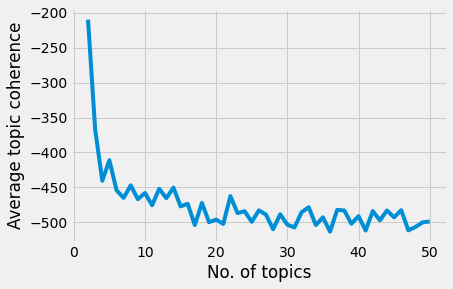

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(measures_specific_tfidf_lda['n_topics'],measures_specific_tfidf_lda['avg_coherence'])
plt.xlabel("No. of topics")
plt.ylabel("Average topic coherence")
plt.show()

In [ ]:
measures_specific_tfidf_lda.sort_values('avg_coherence', ascending = False).iloc[0:50,:]

avg_coherence  n_topics
0     -209.972522         2
1     -366.982423         3
3     -411.027871         5
2     -440.441526         4
6     -446.962246         8
12    -450.253743        14
10    -451.822587        12
4     -453.873325         6
8     -457.924526        10
20    -462.369334        22
5     -464.933194         7
11    -465.342631        13
7     -466.791913         9
16    -472.102367        18
14    -473.385669        16
9     -475.424098        11
13    -476.993283        15
31    -478.288464        33
35    -482.134579        37
44    -482.490250        46
24    -482.714170        26
36    -482.925100        38
42    -482.979621        44
40    -483.794305        42
22    -483.982670        24
30    -485.462730        32
21    -486.694138        23
27    -488.365748        29
25    -488.868096        27
38    -491.030020        40
43    -492.687266        45
33    -492.692466        35
18    -495.967010        20
41    -496.980237        43
48    -498.636449        50
23    -499.196332        25
17    -499.683813        19
47    -499.904677        49
37    -501.928070        39
19    -502.197617        21
28    -503.245393        30
15    -503.762736        17
32    -503.787437        34
46    -506.427348        48
29    -507.160282        31
26    -509.746051        28
45    -511.325702        47
39    -511.565133        41
34    -513.267766        36

### Optimal $\alpha$ and $\beta$ parameters

In [ ]:
lda = LatentDirichletAllocation(n_components = 22,
                                doc_topic_prior = 0.001, # try: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25
                                topic_word_prior = 0.001, # try: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 50,
                                random_state = 123)
lda.fit(tf)

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['match', 'team', 'goal', 'argentina', 'first', 'game', 'messi', 'group', 'half', 'win']
Topic 1:  ['soccer', 'us', 'pelé', 'team', 'before', 'al', 'players', 'saudi', 'statement', 'ronaldo']
Topic 2:  ['messi', 'argentina', 'first', 'game', 'match', 'france', 'goal', 'two', 'team', 'soccer']
Topic 3:  ['portugal', 'ronaldo', 'brazil', 'south', 'korea', 'south korea', 'match', 'switzerland', 'ghana', 'uruguay']
Topic 4:  ['workers', 'migrant', 'rights', 'migrant workers', 'human', 'human rights', 'fifa', 'tournament', 'qatars', 'qatari']
Topic 5:  ['team', 'messi', 'argentina', 'match', 'france', 'first', 'tournament', 'final', 'soccer', 'year']
Topic 6:  ['argentina', 'live', 'football', 'soccer', 'match', 'tournament', 'two', 'like', 'game', 'first']
Topic 7:  ['russian', 'ukraine', 'ukrainian', 'russia', 'us', 'city', 'also', 'war', 'forces', 'president']
Topic 8:  ['us', 'soccer', 'team', 'cnn', 'people', 'told', 'two', 'football', 'fans', 'also']
Topic 9:  ['people', 'al

In [ ]:
params = []
for alpha in [0.0001, 0.001, 0.01, 0.05, 0.1]:
    for beta in [0.0001, 0.001, 0.01, 0.05, 0.1]:
        for vectorizer_name in ['tf','tf-idf']:

            if(vectorizer_name == 'tf'):
                print(alpha, beta, 'tf')
                lda = LatentDirichletAllocation(n_components = 22,
                                                doc_topic_prior = alpha,
                                                topic_word_prior = beta,
                                                learning_method = 'online',
                                                learning_offset = 50.0,
                                                max_iter = 50,
                                                random_state = 123)
                lda.fit(tf)
                avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)
                params.append([alpha, beta, 'tf', avg_coherence])

            if(vectorizer_name == 'tf-idf'):
                print(alpha, beta, 'tf-idf')
                lda = LatentDirichletAllocation(n_components = 22,
                                                doc_topic_prior = alpha,
                                                topic_word_prior = beta,
                                                learning_method = 'online',
                                                learning_offset = 50.0,
                                                max_iter = 50,
                                                random_state = 123)
                lda.fit(tfidf)
                avg_coherence = get_average_topic_coherence(tf, lda.components_, 25)
                params.append([alpha, beta, 'tf-idf', avg_coherence])

0.0001 0.0001 tf
0.0001 0.0001 tf-idf
0.0001 0.001 tf
0.0001 0.001 tf-idf
0.0001 0.01 tf
0.0001 0.01 tf-idf
0.0001 0.05 tf
0.0001 0.05 tf-idf
0.0001 0.1 tf
0.0001 0.1 tf-idf
0.001 0.0001 tf
0.001 0.0001 tf-idf
0.001 0.001 tf
0.001 0.001 tf-idf
0.001 0.01 tf
0.001 0.01 tf-idf
0.001 0.05 tf
0.001 0.05 tf-idf
0.001 0.1 tf
0.001 0.1 tf-idf
0.01 0.0001 tf
0.01 0.0001 tf-idf
0.01 0.001 tf
0.01 0.001 tf-idf
0.01 0.01 tf
0.01 0.01 tf-idf
0.01 0.05 tf
0.01 0.05 tf-idf
0.01 0.1 tf
0.01 0.1 tf-idf
0.05 0.0001 tf
0.05 0.0001 tf-idf
0.05 0.001 tf
0.05 0.001 tf-idf
0.05 0.01 tf
0.05 0.01 tf-idf
0.05 0.05 tf
0.05 0.05 tf-idf
0.05 0.1 tf
0.05 0.1 tf-idf
0.1 0.0001 tf
0.1 0.0001 tf-idf
0.1 0.001 tf
0.1 0.001 tf-idf
0.1 0.01 tf
0.1 0.01 tf-idf
0.1 0.05 tf
0.1 0.05 tf-idf
0.1 0.1 tf
0.1 0.1 tf-idf


In [ ]:
# below, we make the output (list) a pandas DataFrame with intuitive colnames
params_df = pd.DataFrame(params).rename(columns={
    0: 'alpha', 1: 'beta', 2: 'vectorizer', 3: 'avg_coherence'
})

save_object(params_df, '/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/cnn/cnn_data/params_df_cnn_world_cup.pkl')

In [ ]:
with open("/Users/adamjj/Desktop/Data Science and BA/Topic modelling/final_project_topic_modelling_world_cup_qatar/cnn/cnn_data/params_df_cnn_world_cup.pkl", "rb") as fp:
    params_df = pickle.load(fp)

In [ ]:
params_df.sort_values('avg_coherence', ascending = False).iloc[0:50,:]


alpha    beta vectorizer  avg_coherence
44  0.1000  0.0100         tf    -204.006580
40  0.1000  0.0001         tf    -204.455686
42  0.1000  0.0010         tf    -204.461116
46  0.1000  0.0500         tf    -205.221075
36  0.0500  0.0500         tf    -205.729977
48  0.1000  0.1000         tf    -206.775352
32  0.0500  0.0010         tf    -207.616414
38  0.0500  0.1000         tf    -207.643828
30  0.0500  0.0001         tf    -207.683504
34  0.0500  0.0100         tf    -207.803109
28  0.0100  0.1000         tf    -209.001671
20  0.0100  0.0001         tf    -209.258096
22  0.0100  0.0010         tf    -209.394333
12  0.0010  0.0010         tf    -209.579468
4   0.0001  0.0100         tf    -209.633571
2   0.0001  0.0010         tf    -209.726940
10  0.0010  0.0001         tf    -209.781706
0   0.0001  0.0001         tf    -209.829982
14  0.0010  0.0100         tf    -209.855970
26  0.0100  0.0500         tf    -210.036765
24  0.0100  0.0100         tf    -211.123658
8   0.0001  0.1000         tf    -211.561288
18  0.0010  0.1000         tf    -211.666933
6   0.0001  0.0500         tf    -211.688626
16  0.0010  0.0500         tf    -211.718593
19  0.0010  0.1000     tf-idf    -451.520445
9   0.0001  0.1000     tf-idf    -453.476329
7   0.0001  0.0500     tf-idf    -453.645025
21  0.0100  0.0001     tf-idf    -454.477188
23  0.0100  0.0010     tf-idf    -455.874104
17  0.0010  0.0500     tf-idf    -456.424172
15  0.0010  0.0100     tf-idf    -456.680062
5   0.0001  0.0100     tf-idf    -457.332053
3   0.0001  0.0010     tf-idf    -457.594023
29  0.0100  0.1000     tf-idf    -457.767595
1   0.0001  0.0001     tf-idf    -457.775439
11  0.0010  0.0001     tf-idf    -457.901675
13  0.0010  0.0010     tf-idf    -457.988426
25  0.0100  0.0100     tf-idf    -458.125151
39  0.0500  0.1000     tf-idf    -461.064088
27  0.0100  0.0500     tf-idf    -461.676929
37  0.0500  0.0500     tf-idf    -463.464597
33  0.0500  0.0010     tf-idf    -467.577593
31  0.0500  0.0001     tf-idf    -467.577593
35  0.0500  0.0100     tf-idf    -468.954085
47  0.1000  0.0500     tf-idf    -477.383288
49  0.1000  0.1000     tf-idf    -477.704133
45  0.1000  0.0100     tf-idf    -483.867080
41  0.1000  0.0001     tf-idf    -484.865821
43  0.1000  0.0010     tf-idf    -485.036269

In [ ]:
fig = px.scatter(params_df[params_df['vectorizer']=='tf'], x="alpha", y="beta", color="avg_coherence")
fig.show()

In [ ]:
fig = px.scatter(params_df[params_df['vectorizer']=='tf-idf'], x="alpha", y="beta", color="avg_coherence")
fig.show()

### LDA with better specified $\alpha$ and $\beta$

In [ ]:
lda = LatentDirichletAllocation(n_components = 22,
                                doc_topic_prior = 0.1,
                                topic_word_prior = 0.01,
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 50,
                                random_state = 123)
lda.fit(tf) # TF for now

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['match', 'argentina', 'team', 'goal', 'game', 'first', 'messi', 'group', 'france', 'win']
Topic 1:  ['soccer', 'us', 'pelé', 'team', 'before', 'al', 'players', 'saudi', 'statement', 'ronaldo']
Topic 2:  ['messi', 'argentina', 'first', 'game', 'match', 'goal', 'france', 'two', 'team', 'win']
Topic 3:  ['brazil', 'match', 'portugal', 'ronaldo', 'south', 'first', 'goal', 'team', 'korea', 'south korea']
Topic 4:  ['workers', 'migrant', 'migrant workers', 'rights', 'human rights', 'human', 'tournament', 'fifa', 'qatars', 'qatari']
Topic 5:  ['team', 'messi', 'argentina', 'france', 'match', 'first', 'tournament', 'final', 'two', 'year']
Topic 6:  ['argentina', 'football', 'live', 'match', 'two', 'soccer', 'tournament', 'like', 'game', 'first']
Topic 7:  ['russian', 'ukraine', 'ukrainian', 'russia', 'us', 'city', 'also', 'people', 'war', 'president']
Topic 8:  ['us', 'soccer', 'team', 'people', 'cnn', 'told', 'two', 'football', 'fans', 'also']
Topic 9:  ['people', 'tournament', 'al

In [ ]:
lda = LatentDirichletAllocation(n_components = 22, # let us stay with 30, as that is what topic coherence initially recommended
                                doc_topic_prior = 0.001,
                                topic_word_prior = 0.1,
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 50,
                                random_state = 123)
lda.fit(tfidf) # TF-IDF now

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['messi', 'match', 'holders', 'us national', 'statement said', 'argentina', 'amini', 'stadium monday', 'least five', 'gone play']
Topic 1:  ['milan', 'need know', 'costa rica', 'given', 'players', 'achieving', 'mariupol', 'program', 'dominik livaković', 'before first']
Topic 2:  ['ronaldo', 'messi', 'because something', 'magic', 'angel di', 'croatias', 'new york times', 'final whistle during', 'cnn', 'rashford']
Topic 3:  ['fifa', 'ronaldo', 'rights', 'human rights', 'ten hag', 'match', 'saudi', 'host', 'commit', 'does get']
Topic 4:  ['workers', 'migrant workers', 'us', 'drugs', 'construction', 'migrant', 'president', 'berhalter', 'fifa', 'wednesday']
Topic 5:  ['golf', 'per', 'earlier today', 'grant', 'finals', 'heart', 'term', 'win game', 'said referring', 'feet']
Topic 6:  ['make match', 'licensed venues', 'touched', 'contributed reporting post', 'sides first', 'along way', 'human rights death', 'impossible', 'hit back', 'slowly']
Topic 7:  ['ukraine', 'russian', 'us', 'f

### LDA with higher number of iterations performed

In [ ]:
lda = LatentDirichletAllocation(n_components = 22, # let us stay with 30, as that is what topic coherence initially recommended
                                doc_topic_prior = 0.1,
                                topic_word_prior = 0.01,
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 150,
                                random_state = 123)
lda.fit(tf) # TF for now

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['match', 'team', 'argentina', 'game', 'goal', 'first', 'messi', 'group', 'france', 'win']
Topic 1:  ['soccer', 'us', 'pelé', 'team', 'before', 'al', 'players', 'saudi', 'statement', 'ronaldo']
Topic 2:  ['messi', 'argentina', 'first', 'game', 'match', 'goal', 'france', 'two', 'team', 'win']
Topic 3:  ['brazil', 'match', 'portugal', 'ronaldo', 'first', 'south', 'team', 'goal', 'korea', 'south korea']
Topic 4:  ['workers', 'rights', 'migrant', 'migrant workers', 'human rights', 'human', 'tournament', 'fifa', 'qatars', 'qatari']
Topic 5:  ['team', 'messi', 'argentina', 'france', 'match', 'first', 'tournament', 'final', 'two', 'year']
Topic 6:  ['argentina', 'football', 'live', 'match', 'two', 'soccer', 'tournament', 'like', 'game', 'first']
Topic 7:  ['russian', 'ukraine', 'ukrainian', 'russia', 'us', 'city', 'also', 'war', 'president', 'forces']
Topic 8:  ['us', 'soccer', 'team', 'people', 'cnn', 'told', 'two', 'football', 'fans', 'also']
Topic 9:  ['people', 'tournament', 'al

In [ ]:
lda.perplexity(tf)

4248.362528009484

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title = '', subplotx = 2, subploty = 5):
    fig, axes = plt.subplots(subplotx, subploty, figsize=(60, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=30)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

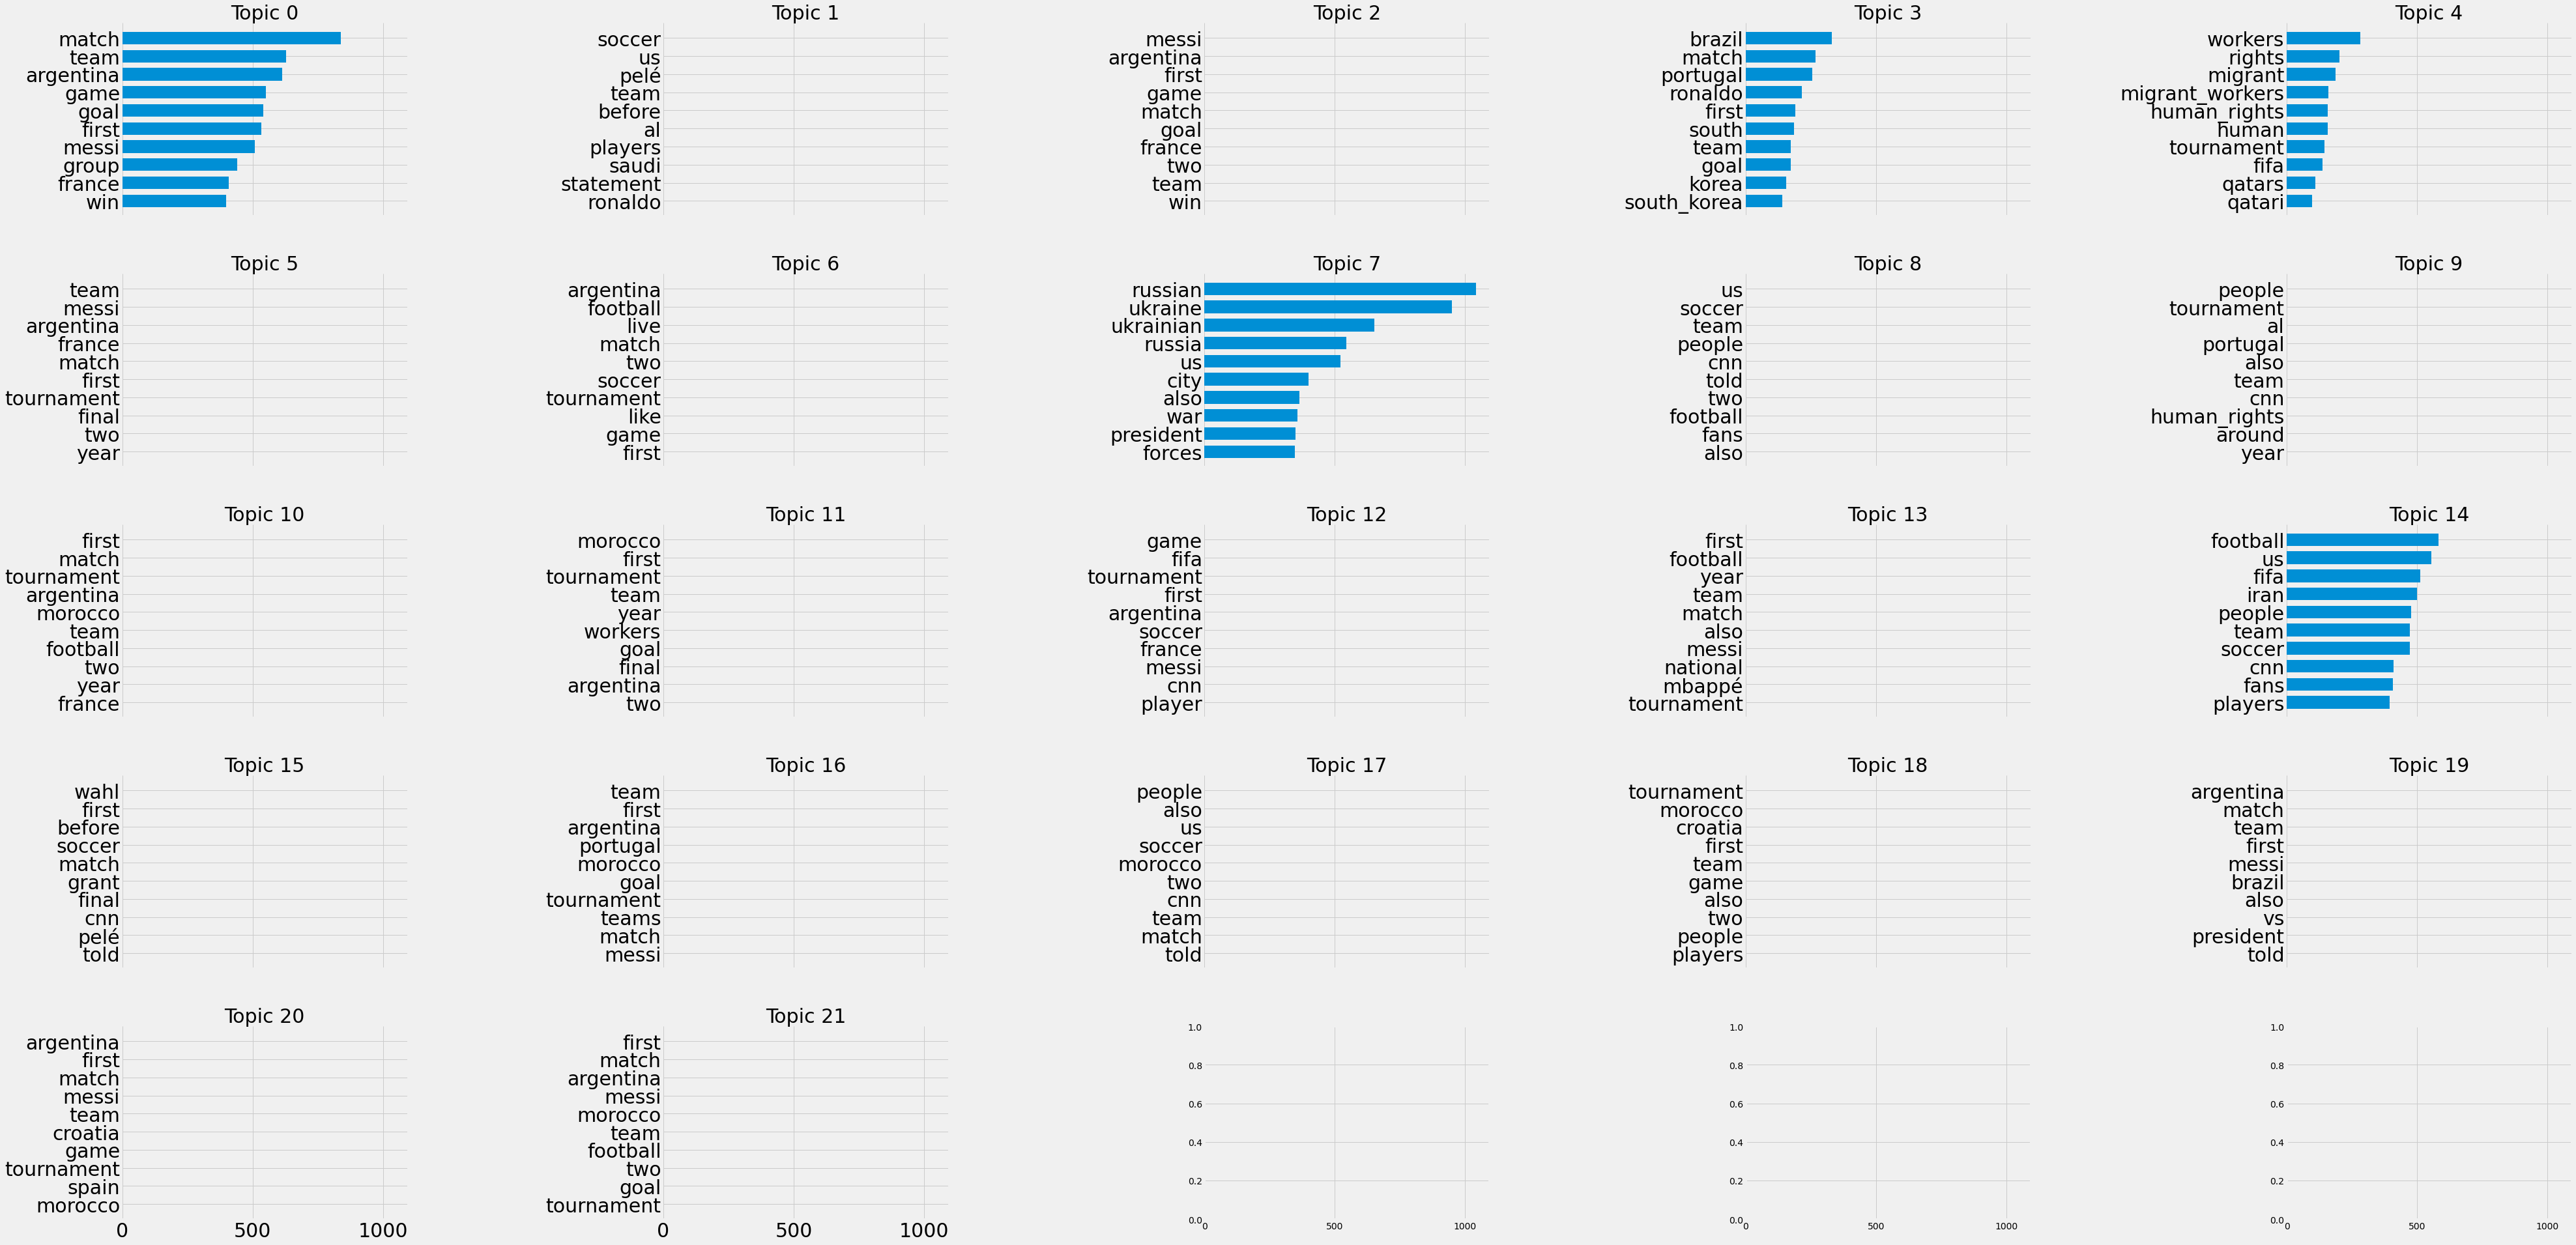

In [ ]:
plot_top_words(lda, tf_feature_names, 10, title = '', subplotx = 5, subploty = 5)

In [ ]:
def topic_by_index(model, feature_names, no_top_words, topic_index):
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx == topic_index):
            text = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
            wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
            plt.figure()
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.show()

In [ ]:
import re
tf_feature_names = [re.sub(' ', '_', x) for x in tf_feature_names]

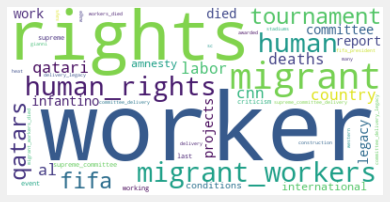

In [ ]:
topic_by_index(lda, tf_feature_names, 50, 4)

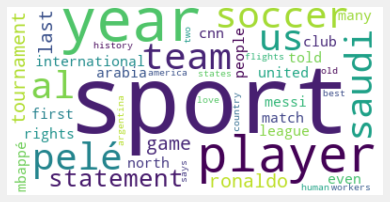

In [ ]:
topic_by_index(lda, tf_feature_names, 50, 1)

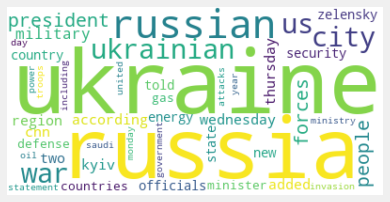

In [ ]:
topic_by_index(lda, tf_feature_names, 50, 7)

In [ ]:
lda = LatentDirichletAllocation(n_components = 22, # let us stay with 30, as that is what topic coherence initially recommended
                                doc_topic_prior = 0.001,
                                topic_word_prior = 0.1,
                                learning_method = 'online',
                                learning_offset = 50.0,
                                max_iter = 150,
                                random_state = 123)
lda.fit(tfidf) # TF-IDF now

for index, component in enumerate(lda.components_): #taking model's components
                                                    #(values from reconstructed Document-Term Matrix)
    zipped = zip(tf_feature_names, component) #taking together tokens' names with components
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #top 10 terms per topic
    top_terms_list=list(dict(top_terms_key).keys()) #taking only tokens, no weights

    print("Topic "+str(index)+": ",top_terms_list) #prints top 10 tokens per topic

Topic 0:  ['messi', 'match', 'holders', 'us_national', 'statement_said', 'argentina', 'amini', 'stadium_monday', 'least_five', 'gone_play']
Topic 1:  ['milan', 'need_know', 'costa_rica', 'given', 'players', 'achieving', 'mariupol', 'program', 'dominik_livaković', 'before_first']
Topic 2:  ['ronaldo', 'messi', 'because_something', 'magic', 'angel_di', 'croatias', 'new_york_times', 'final_whistle_during', 'cnn', 'rashford']
Topic 3:  ['fifa', 'ronaldo', 'rights', 'human_rights', 'ten_hag', 'match', 'saudi', 'host', 'commit', 'does_get']
Topic 4:  ['workers', 'migrant_workers', 'us', 'drugs', 'construction', 'migrant', 'president', 'berhalter', 'fifa', 'wednesday']
Topic 5:  ['golf', 'per', 'earlier_today', 'grant', 'finals', 'heart', 'term', 'win_game', 'said_referring', 'feet']
Topic 6:  ['make_match', 'licensed_venues', 'touched', 'contributed_reporting_post', 'sides_first', 'along_way', 'human_rights_death', 'impossible', 'hit_back', 'slowly']
Topic 7:  ['ukraine', 'russian', 'us', 'f

In [ ]:
lda.perplexity(tfidf)

70937.55930195795

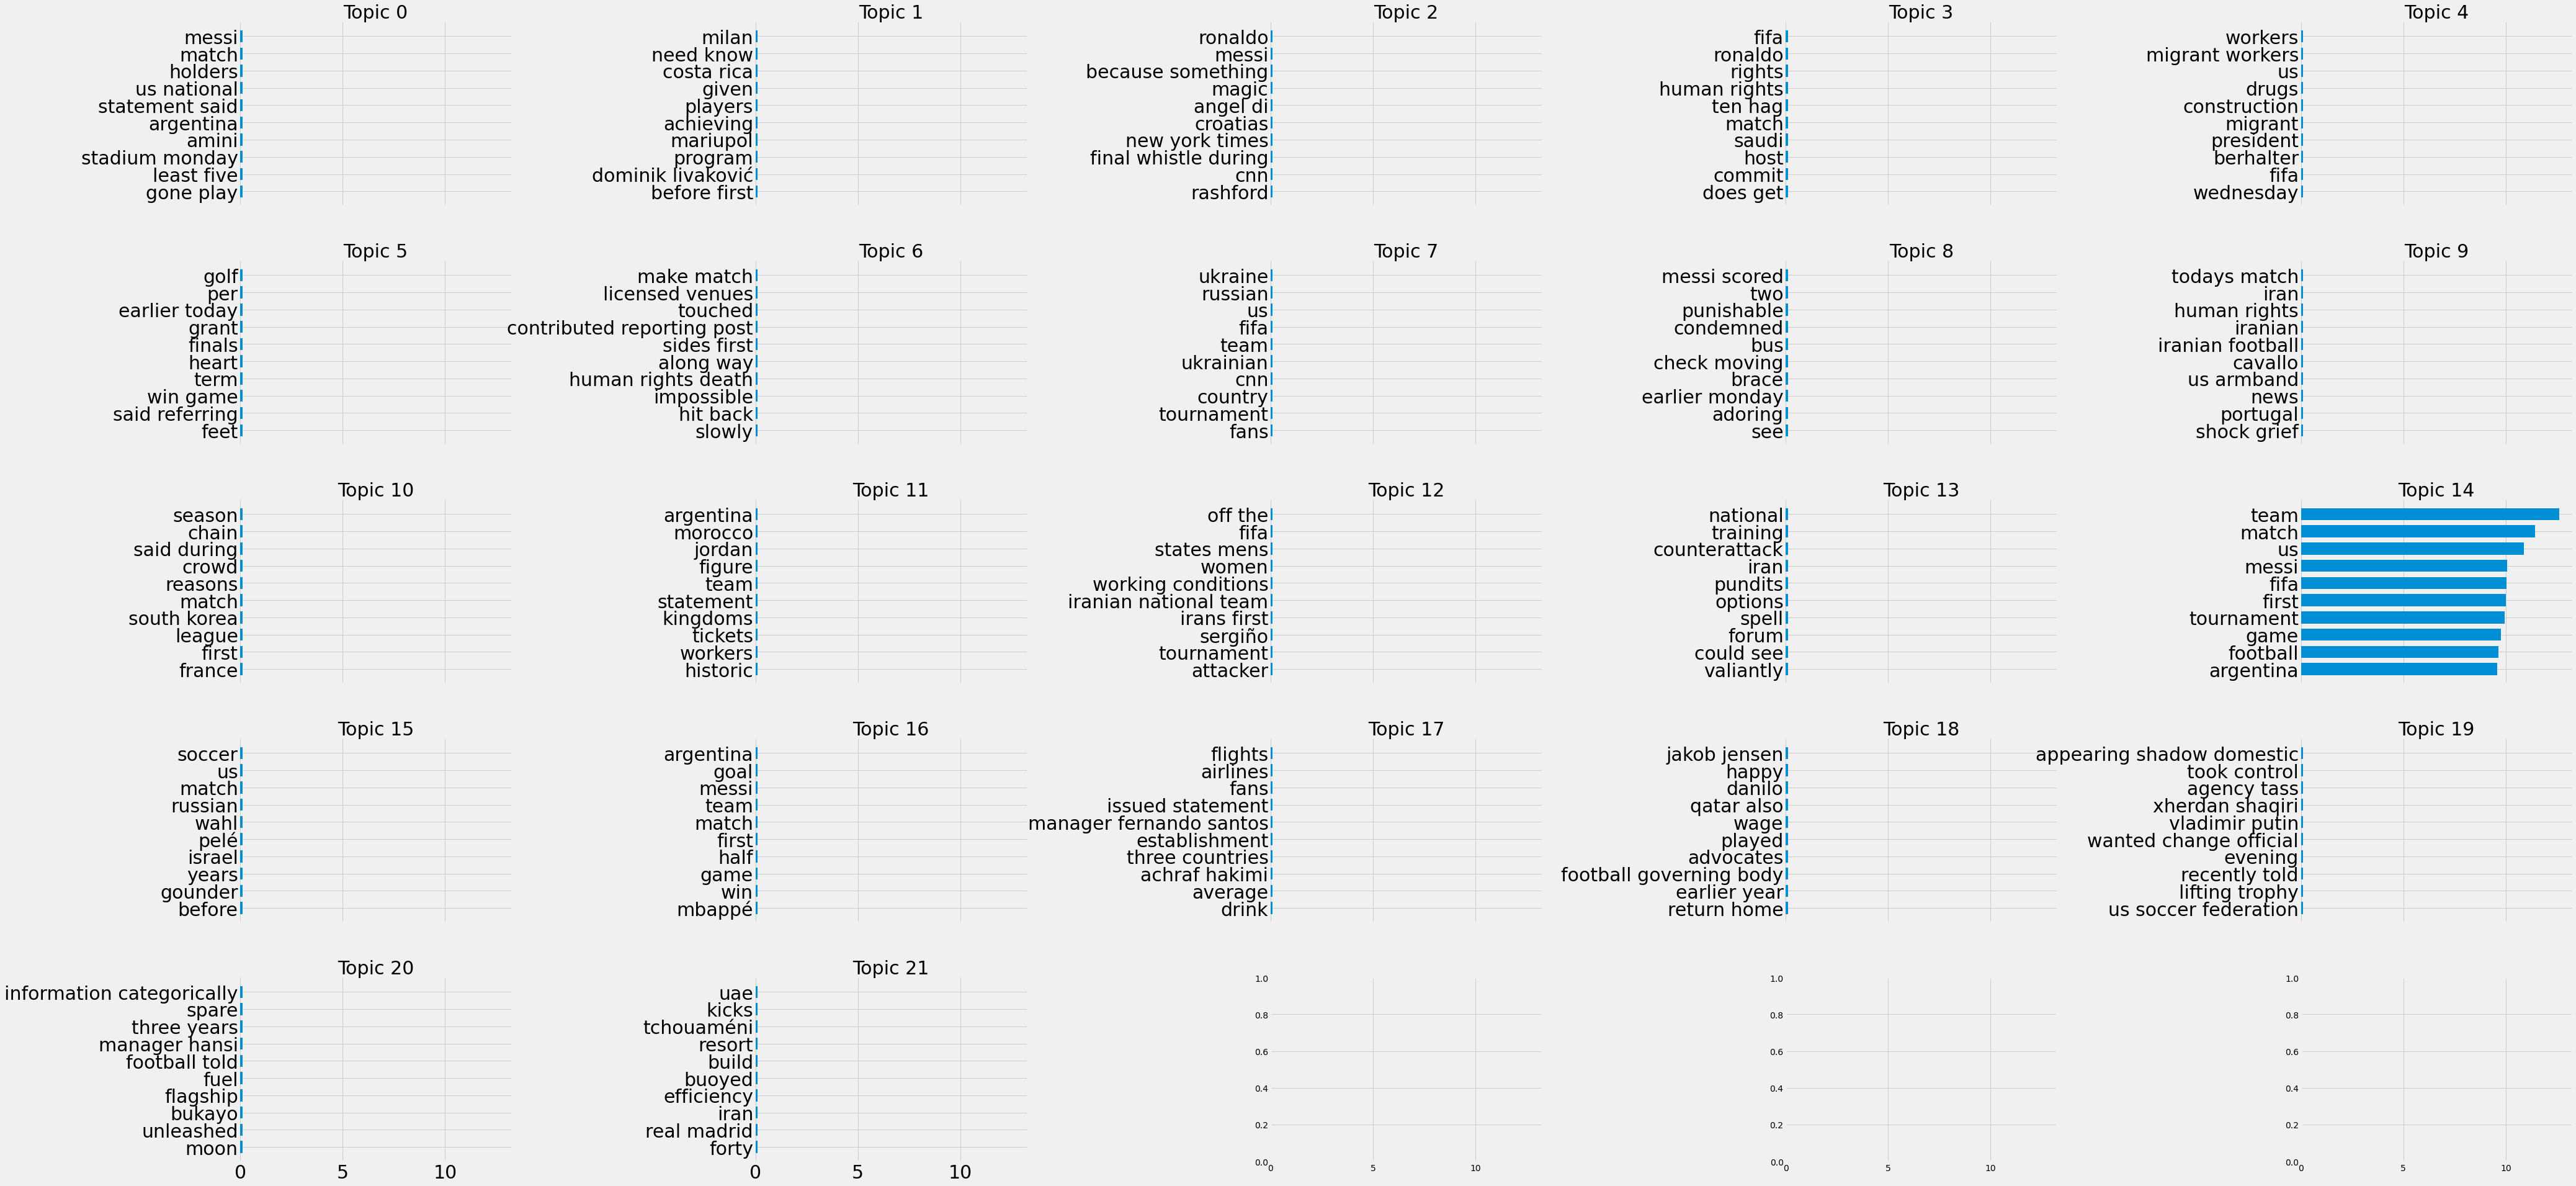

In [ ]:
plot_top_words(lda, tfidf_feature_names, 10, title = '', subplotx = 5, subploty = 5)

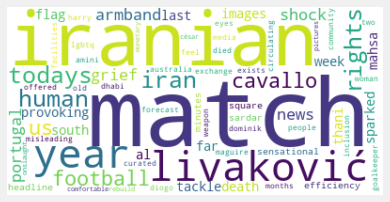

In [ ]:
topic_by_index(lda, tfidf_feature_names, 50, 9)

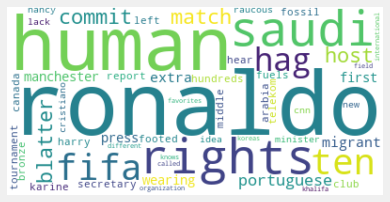

In [ ]:
topic_by_index(lda, tfidf_feature_names, 50, 3)

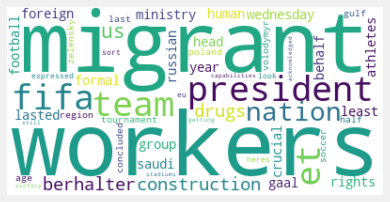

In [ ]:
topic_by_index(lda, tfidf_feature_names, 50, 4)

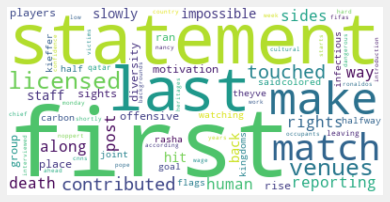

In [ ]:
topic_by_index(lda, tfidf_feature_names, 50, 6)

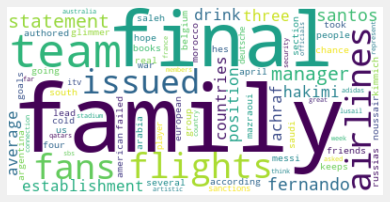

In [ ]:
topic_by_index(lda, tfidf_feature_names, 50, 17)

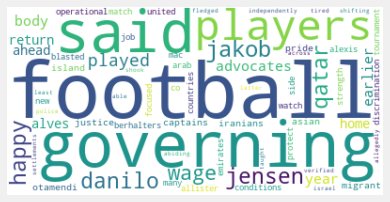

In [ ]:
topic_by_index(lda, tfidf_feature_names, 50, 18)

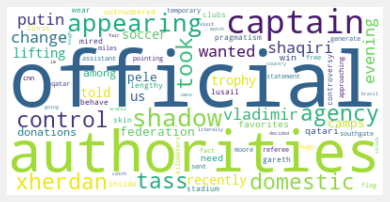

In [ ]:
topic_by_index(lda, tfidf_feature_names, 50, 19)